### Load Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import time
import random
import os
import PIL
from numpy import loadtxt
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt


In [2]:
!pip install xgboost

distributed 1.21.8 requires msgpack, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Load Data ####

In [3]:
img_dir = "C:\\NICE\\TMF_DATA\\BITSPilani\\IITH\Classess\\7.AdvancedML\\Project\\chest_xray\\test" # Enter Directory of all images 
dirlist = [ item for item in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, item)) ]
## Load images and flatten
Normal_Image=[]
PNEUMONIA_Image=[]
basewidth=400
hsize=400
for item in dirlist:
    if(item=='NORMAL'):
            data_path = os.path.join(img_dir+'\\'+item,'*jpeg')
            files = glob.glob(data_path)
            for f1 in files:
                img = Image.open(f1)
                img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
                im_list=[item for sublist in np.array(img).tolist() for item in sublist]
                Normal_Image.append(im_list)
    elif(item=='PNEUMONIA'):
        data_path = os.path.join(img_dir+'\\'+item,'*jpeg')
        files = glob.glob(data_path)
        for f1 in files:
            img = Image.open(f1)
            img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            im_list=[item for sublist in np.array(img).tolist() for item in sublist]
            PNEUMONIA_Image.append(im_list)

        


In [4]:
### Assign targets
Normal_target=[0] * len(Normal_Image)
PNEUMONIA_target=[1] * len(PNEUMONIA_Image)

In [5]:
Normal_Image_df=pd.DataFrame(Normal_Image)
Normal_Image_df['target']=pd.DataFrame(Normal_target)
PNEUMONIA_Image_df=pd.DataFrame(PNEUMONIA_Image)
PNEUMONIA_Image_df['target']=pd.DataFrame(PNEUMONIA_target)
print(Normal_Image_df.head())
print(PNEUMONIA_Image_df.head())

    0   1   2   3   4   5   6   7   8   9   ...    159991  159992  159993  \
0  27  34  32  31  32  33  33  32  31  31   ...        33      33      33   
1  11  38  36  33  30  28  28  25  25  48   ...        32      33      34   
2  34  38  37  38  37  36  37  37  35  34   ...        34      36      36   
3  58  76  73  73  72  74  75  74  73  77   ...       136     133     127   
4  35  42  40  40  39  40  41  38  37  40   ...        45      44      42   

   159994  159995  159996  159997  159998  159999  target  
0      34      32      32      31      35      29       0  
1      33      32      33      33      34      21       0  
2      33      34      38      34      36      30       0  
3     134     143     136     122     132     104       0  
4      45      45      44      45      47      39       0  

[5 rows x 160001 columns]
     0    1    2    3    4    5    6    7    8    9   ...    159991  159992  \
0   15   20   18   16   17   21   28   32   36   35   ...         0    

In [6]:
Final_df=pd.concat([Normal_Image_df,PNEUMONIA_Image_df])

### Probablity Distribution Wise Labeling 

In [7]:
def pdfCalculator(element,mean1,std1,mean2,std2,absCutoff=0.0005,pctCutoff=0.2,code='HLLH'):
    import scipy.stats
    prob1     = scipy.stats.norm(mean1, std1).pdf(element)
    prob2     = scipy.stats.norm(mean2, std2).pdf(element)
    diff      = (prob1-prob2)
    absDiff   = abs(diff)
    pctDiff=absDiff/prob1
    if(code=='HLLH'):
        lower_bound=mean1-std1
        upper_bound=mean1+std1
        label = np.where((diff<0)&(absDiff>absCutoff)&(element<(mean1-std1)),
                 -1,
                 np.where((diff>0)&(absDiff>absCutoff)&(element>(mean1+std1)),
                          1,
                          np.where((diff>0)&(pctDiff>pctCutoff)&(element>=lower_bound)&(element<=upper_bound),
                                   1,
                                   0
                         )
                        )
                    )
    if(code=='HHLL'):
        lower_bound=mean2-std2
        upper_bound=mean2+std2
        label = np.where((diff>0)&(absDiff>absCutoff)&(element<(mean1-1.5*std1)),
                    1,
                    np.where((diff>0)&(absDiff>absCutoff)&(element>(mean1+1.5*std1)),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=lower_bound)&(element<=upper_bound),
                                -1,
                                0
                        )
                    )
                )
    if(code=='HHLH'):
        lower_bound=mean1-std1
        upper_bound=mean2+std2
        label = np.where((diff<0)&(element<mean2),
                    -1,
                    np.where((diff>0)&(element>mean1),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=mean2)&(element<=upper_bound),
                                -1,
                                  np.where((diff>0)&(pctDiff>pctCutoff)&(element<=mean1)&(element>=lower_bound),
                                  1,
                                  0
                                          )
                                    )
                        )
                    )
                
    if(code=='HLLL'):
        lower_bound=mean1-1.5*std1
        upper_bound=mean2+1.5*std2
        label = np.where((diff<0)&(element<mean2),
                    -1,
                    np.where((diff>0)&(element>mean1),
                            1,
                            np.where((diff<0)&(pctDiff>pctCutoff)&(element>=mean2)&(element<=upper_bound),
                                -1,
                                  np.where((diff>0)&(pctDiff>pctCutoff)&(element<=mean1)&(element>=lower_bound),
                                  1,
                                  0
                                          )
                                    )
                        )
                    )
                
    return label

In [8]:
def labelGeneratorWithProbDist(df,e=0.3,absCutoff=0.0005,pctCutoff=0.2,nCol=3):
    import scipy.stats
    labelMasterDF = pd.DataFrame()
    subCol = random.sample(df.columns.tolist(),k=nCol)
    i=0
    for series in list(subCol):
        labelDF   = pd.DataFrame()
        median    = np.median(df[df.columns[series]])
        std       = np.std(df[df.columns[series]])
        high_mean = median + e*median
        low_std   = std    - e*std
        low_mean  = median - e*median
        high_std  = std    + e*std
        ############ Combination 1 := Probablity-1 High_Mean, Low_SD && Probablity-2 Low_Mean, High_SD ############
        
        labelDF['ProbDist_1_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,low_std,low_mean,high_std,absCutoff,pctCutoff,code='HLLH'))
        labelDF['ProbDist_2_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[0]]==0,0,np.where(labelDF[labelDF.columns[0]]==-1,1,-1))
        
        ############ Combination 2 := Probablity-1 High_Mean, High_SD && Probablity-2 Low_Mean, High_SD ############
        
        labelDF['ProbDist_3_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,high_std,low_mean,high_std,absCutoff,pctCutoff,code='HHLH'))
        #print(labelDF['ProbDist_3_Column_3'].unique())
        labelDF['ProbDist_4_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[2]]==0,0,np.where(labelDF[labelDF.columns[2]]==-1,1,-1))
        
        ############ Combination 3 := Probablity-1 High_Mean, High_SD && Probablity-2 Low_Mean, Low_SD ############

        labelDF['ProbDist_5_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,high_std,low_mean,low_std,absCutoff,pctCutoff,code='HHLL'))
        labelDF['ProbDist_6_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[4]]==0,0,np.where(labelDF[labelDF.columns[4]]==-1,1,-1))
                
        ############ Combination 4 := Probablity-1 High_Mean, Low_SD && Probablity-2 Low_Mean, Low_SD ############
        
        labelDF['ProbDist_7_Column_{}'.format(series)] = df[df.columns[series]].apply(lambda x: pdfCalculator(x,high_mean,low_std,low_mean,low_std,absCutoff,pctCutoff,code='HLLL'))
        labelDF['ProbDist_8_ColumnR_{}'.format(series)] = np.where(labelDF[labelDF.columns[6]]==0,0,np.where(labelDF[labelDF.columns[6]]==-1,1,-1))
               
        if(i==0):
            labelMasterDF = labelDF.copy()
        else:
            labelMasterDF = pd.concat([labelMasterDF,labelDF],axis=1,sort=False)
        i=i+1 
    return labelMasterDF

In [9]:
## This function calculates different accuracy metric for labels created by probabilistic labeling function
def calculate_accuracy_metric(label_df,data_df, target_col):
    cols=label_df.columns
    Label_Name=[]
    Precision=[]
    Recall=[]
    F1=[]
    Accuracy=[]
    Coverage=[]
    for col in cols:
        a=pd.crosstab(data_df[target_col],label_df[col])
        P=a[1][1]/(a[1][1]+a[1][0])
        R=a[1][1]/(a[1][1]+a[-1][1])
        f1=2*(P*R)/(P+R)
        Acc=(a[-1][0]+a[1][1])/(a[-1][0]+a[-1][1]+a[1][0]+a[1][1])
        cvg=(a[1].sum()+a[-1].sum())/(a.sum().sum())
        Label_Name.append(col)
        Precision.append(P)
        Recall.append(R)
        F1.append(f1)
        Accuracy.append(Acc)
        Coverage.append(cvg)
    Accuracy_Metric=pd.concat([pd.DataFrame(Label_Name),pd.DataFrame(Coverage),pd.DataFrame(Precision),pd.DataFrame(Recall),pd.DataFrame(F1),pd.DataFrame(Accuracy)],axis=1)
    Accuracy_Metric.columns=['Label_Name','Coverage','Precision','Recall','F1','Accuracy']
    Accuracy_Metric=Accuracy_Metric.sort_values(by=['Coverage','Precision'],ascending=False)
    return Accuracy_Metric 


In [10]:
### generative lables with various cut-off of probability
def Gen_Label_Cutoff(train_marginals_df,marginal_col):
    train_marginals_df['labels_gen_4'] = np.where(train_marginals_df[marginal_col]>0.40, 1,0)
    train_marginals_df['labels_gen_5'] = np.where(train_marginals_df[marginal_col]>0.50, 1,0)
    train_marginals_df['labels_gen_6'] = np.where(train_marginals_df[marginal_col]>0.60, 1,0)
    train_marginals_df['labels_gen_7'] = np.where(train_marginals_df[marginal_col]>0.70, 1,0)
    train_marginals_df['labels_gen_8'] = np.where(train_marginals_df[marginal_col]>0.80, 1,0)
    train_marginals_df['labels_gen_9'] = np.where(train_marginals_df[marginal_col]>0.90, 1,0)
    Label_Gen=train_marginals_df.drop(marginal_col, axis=1)
    return Label_Gen

In [11]:
def calculate_accuracy_GM(Label_Gen,data_df, target_col):
    cols=Label_Gen.columns
    Cutoff=[]
    Precision=[]
    Recall=[]
    F1=[]
    Accuracy=[]
    for col in cols:
        a=pd.crosstab(data_df[target_col],Label_Gen[col])
        P=a[1][1]/(a[1][1]+a[1][0])
        R=a[1][1]/(a[1][1]+a[0][1])
        f1=2*(P*R)/(P+R)
        Acc=(a[0][0]+a[1][1])/(a[0][0]+a[0][1]+a[1][0]+a[1][1])
        Cutoff.append(col)
        Precision.append(P)
        Recall.append(R)
        F1.append(f1)
        Accuracy.append(Acc)
    Accuracy_Metric_GM=pd.concat([pd.DataFrame(Cutoff),pd.DataFrame(Precision),pd.DataFrame(Accuracy),pd.DataFrame(F1),pd.DataFrame(Recall)],axis=1)
    Accuracy_Metric_GM.columns=['Cutoff','Precision','Accuracy','F1','Recall']
    Accuracy_Metric_GM=Accuracy_Metric_GM.sort_values(by=['Precision','Accuracy'],ascending=False)
    return Accuracy_Metric_GM

### First Experiment with 5 features

In [12]:
### Create Label Matrix
Label_df_5=labelGeneratorWithProbDist(Final_df,nCol=5,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf=Label_df_5.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels=tempdf.columns[tempdf.isna().any()].tolist()
## Drop these cols
Label_df_5 = Label_df_5.drop(cols_2_labels, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric=calculate_accuracy_metric(Label_df_5,Final_df, 'target')
Label_Accuracy_Metric.head(10)
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM=Label_Accuracy_Metric[Label_Accuracy_Metric['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM=Label_df_5[Label_to_GM]


C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Inferred cardinality: 2


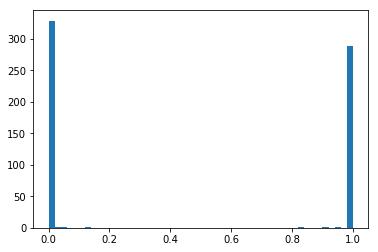

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.690476,0.504,0.483333,0.371795
0,labels_gen_4,0.688679,0.504,0.485050,0.374359
1,labels_gen_5,0.688679,0.504,0.485050,0.374359
2,labels_gen_6,0.688679,0.504,0.485050,0.374359
3,labels_gen_7,0.688679,0.504,0.485050,0.374359
4,labels_gen_8,0.688679,0.504,0.485050,0.374359


In [13]:
### Train generative model
train_5 = sparse.csr_matrix(Label_Matrix_to_GM.values)
GM_5 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
train_5_marginals = GM_5.marginals(train_5)
train_5_marginals.shape
plt.hist(train_5_marginals, bins=50)
plt.show()
train_5_marginals_df=pd.DataFrame(train_5_marginals)
train_5_marginals_df.columns=['train_5_marginals']
train_5_marginals_df=pd.DataFrame(train_5_marginals)
train_5_marginals_df.columns=['train_5_marginals']
Label_Gen_5=Gen_Label_Cutoff(train_5_marginals_df,'train_5_marginals')
Accuracy_Metric_GM_5=calculate_accuracy_GM(Label_Gen_5,Final_df,'target')
Accuracy_Metric_GM_5

## Second Experiment with 10 features

In [14]:
### Create Label Matrix
Label_df_10=labelGeneratorWithProbDist(Final_df,nCol=10,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_10=Label_df_10.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_10=tempdf_10.columns[tempdf_10.isna().any()].tolist()
## Drop these cols
Label_df_10 = Label_df_10.drop(cols_2_labels_10, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_10=calculate_accuracy_metric(Label_df_10,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_10=Label_Accuracy_Metric_10[Label_Accuracy_Metric_10['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_10=Label_df_10[Label_to_GM_10]
Label_Accuracy_Metric_10.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
68,ProbDist_7_Column_87918,0.9792,0.657980,0.528796,0.586357,0.534314
69,ProbDist_8_ColumnR_87918,0.9792,0.590164,0.471204,0.524017,0.465686
48,ProbDist_7_Column_127291,0.9680,0.651007,0.513228,0.573964,0.523967
49,ProbDist_8_ColumnR_127291,0.9680,0.599349,0.486772,0.537226,0.476033
31,ProbDist_8_ColumnR_6879,0.9456,0.701987,0.585635,0.638554,0.593909
25,ProbDist_2_ColumnR_6879,0.9456,0.695341,0.531507,0.602484,0.566836
24,ProbDist_1_Column_6879,0.9456,0.548077,0.468493,0.505170,0.433164
30,ProbDist_7_Column_6879,0.9456,0.519031,0.414365,0.460829,0.406091
44,ProbDist_1_Column_127291,0.9392,0.651007,0.527174,0.582583,0.526405
45,ProbDist_2_ColumnR_127291,0.9392,0.602076,0.472826,0.529680,0.473595


In [15]:
Label_Accuracy_Metric_10.head(10)
#Label_Matrix_to_GM_10.shape

,Label_Name,Coverage,Precision,Recall,F1,Accuracy
68,ProbDist_7_Column_87918,0.9792,0.657980,0.528796,0.586357,0.534314
69,ProbDist_8_ColumnR_87918,0.9792,0.590164,0.471204,0.524017,0.465686
48,ProbDist_7_Column_127291,0.9680,0.651007,0.513228,0.573964,0.523967
49,ProbDist_8_ColumnR_127291,0.9680,0.599349,0.486772,0.537226,0.476033
31,ProbDist_8_ColumnR_6879,0.9456,0.701987,0.585635,0.638554,0.593909
25,ProbDist_2_ColumnR_6879,0.9456,0.695341,0.531507,0.602484,0.566836
24,ProbDist_1_Column_6879,0.9456,0.548077,0.468493,0.505170,0.433164
30,ProbDist_7_Column_6879,0.9456,0.519031,0.414365,0.460829,0.406091
44,ProbDist_1_Column_127291,0.9392,0.651007,0.527174,0.582583,0.526405
45,ProbDist_2_ColumnR_127291,0.9392,0.602076,0.472826,0.529680,0.473595


Inferred cardinality: 2


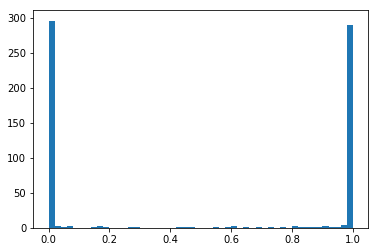

,Cutoff,Precision,Accuracy,F1,Recall
0,labels_gen_4,0.561350,0.4400,0.511173,0.469231
4,labels_gen_8,0.560510,0.4368,0.500000,0.451282
1,labels_gen_5,0.560000,0.4384,0.509091,0.466667
2,labels_gen_6,0.560000,0.4384,0.509091,0.466667
5,labels_gen_9,0.559871,0.4352,0.494993,0.443590
3,labels_gen_7,0.559748,0.4368,0.502825,0.456410


In [16]:
### Train generative model
train_10 = sparse.csr_matrix(Label_Matrix_to_GM_10.values)
GM_10 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_10.train(Label_Matrix_to_GM_10.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_10.values.T.shape[1], reg_param=1e-6)
train_10_marginals = GM_10.marginals(train_10)
train_10_marginals.shape
plt.hist(train_10_marginals, bins=50)
plt.show()
train_10_marginals_df=pd.DataFrame(train_10_marginals)
train_10_marginals_df.columns=['train_10_marginals']
train_10_marginals_df=pd.DataFrame(train_10_marginals)
train_10_marginals_df.columns=['train_10_marginals']
Label_Gen_10=Gen_Label_Cutoff(train_10_marginals_df,'train_10_marginals')
Accuracy_Metric_GM_10=calculate_accuracy_GM(Label_Gen_10,Final_df,'target')
Accuracy_Metric_GM_10

## Second Experiment with 15 features

In [17]:
### Create Label Matrix
Label_df_15=labelGeneratorWithProbDist(Final_df,nCol=15,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_15=Label_df_15.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_15=tempdf_15.columns[tempdf_15.isna().any()].tolist()
## Drop these cols
Label_df_15 = Label_df_15.drop(cols_2_labels_15, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_15=calculate_accuracy_metric(Label_df_15,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_15=Label_Accuracy_Metric_15[Label_Accuracy_Metric_15['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_15=Label_df_15[Label_to_GM_15]
Label_Accuracy_Metric_15.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
103,ProbDist_8_ColumnR_60328,0.9728,0.736842,0.594164,0.657856,0.616776
81,ProbDist_8_ColumnR_79675,0.9728,0.683168,0.546174,0.607038,0.559211
80,ProbDist_7_Column_79675,0.9728,0.563934,0.453826,0.502924,0.440789
102,ProbDist_7_Column_60328,0.9728,0.503289,0.405836,0.449339,0.383224
52,ProbDist_7_Column_122143,0.9712,0.731544,0.575198,0.644018,0.602965
7,ProbDist_8_ColumnR_96896,0.9712,0.636656,0.528000,0.577259,0.522241
6,ProbDist_7_Column_96896,0.9712,0.597973,0.472000,0.527571,0.477759
53,ProbDist_8_ColumnR_122143,0.9712,0.521036,0.424802,0.468023,0.397035
66,ProbDist_7_Column_42642,0.9680,0.756579,0.611702,0.676471,0.636364
67,ProbDist_8_ColumnR_42642,0.9680,0.485050,0.388298,0.431315,0.363636


Inferred cardinality: 2


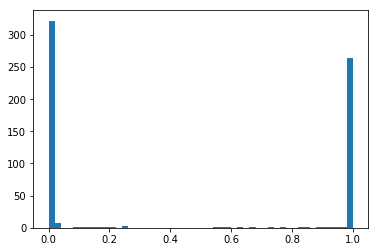

,Cutoff,Precision,Accuracy,F1,Recall
3,labels_gen_7,0.561290,0.4368,0.497143,0.446154
2,labels_gen_6,0.560897,0.4368,0.498575,0.448718
4,labels_gen_8,0.560656,0.4352,0.492086,0.438462
0,labels_gen_4,0.560127,0.4368,0.501416,0.453846
1,labels_gen_5,0.560127,0.4368,0.501416,0.453846
5,labels_gen_9,0.559603,0.4336,0.488439,0.433333


In [18]:
### Train generative model
train_15 = sparse.csr_matrix(Label_Matrix_to_GM_15.values)
GM_15 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_15.train(Label_Matrix_to_GM_15.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_15.values.T.shape[1], reg_param=1e-6)
train_15_marginals = GM_15.marginals(train_15)
train_15_marginals.shape
plt.hist(train_15_marginals, bins=50)
plt.show()
train_15_marginals_df=pd.DataFrame(train_15_marginals)
train_15_marginals_df.columns=['train_15_marginals']
train_15_marginals_df=pd.DataFrame(train_15_marginals)
train_15_marginals_df.columns=['train_15_marginals']
Label_Gen_15=Gen_Label_Cutoff(train_15_marginals_df,'train_15_marginals')
Accuracy_Metric_GM_15=calculate_accuracy_GM(Label_Gen_15,Final_df,'target')
Accuracy_Metric_GM_15

## Second Experiment with 20 features

In [19]:
### Create Label Matrix
Label_df_20=labelGeneratorWithProbDist(Final_df,nCol=20,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_20=Label_df_20.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_20=tempdf_20.columns[tempdf_20.isna().any()].tolist()
## Drop these cols
Label_df_20 = Label_df_20.drop(cols_2_labels_20, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_20=calculate_accuracy_metric(Label_df_20,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_20=Label_Accuracy_Metric_20[Label_Accuracy_Metric_20['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_20=Label_df_20[Label_to_GM_20]
Label_Accuracy_Metric_20.head(10)

,Label_Name,Coverage,Precision,Recall,F1,Accuracy
0,ProbDist_3_Column_104392,0.9792,0.752443,0.601562,0.668596,0.625817
4,ProbDist_7_Column_104392,0.9792,0.752443,0.601562,0.668596,0.625817
1,ProbDist_4_ColumnR_104392,0.9792,0.501639,0.398438,0.444122,0.374183
5,ProbDist_8_ColumnR_104392,0.9792,0.501639,0.398438,0.444122,0.374183
35,ProbDist_8_ColumnR_91145,0.9776,0.752443,0.606299,0.671512,0.630115
34,ProbDist_7_Column_91145,0.9776,0.493421,0.393701,0.437956,0.369885
12,ProbDist_7_Column_118108,0.9760,0.668852,0.539683,0.597365,0.549180
13,ProbDist_8_ColumnR_118108,0.9760,0.570492,0.460317,0.509517,0.450820
56,ProbDist_7_Column_115679,0.9696,0.662252,0.527704,0.587372,0.536304
135,ProbDist_8_ColumnR_124047,0.9696,0.624183,0.506631,0.559297,0.503300


Inferred cardinality: 2


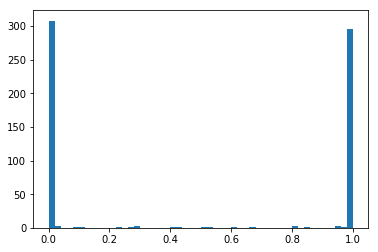

,Cutoff,Precision,Accuracy,F1,Recall
0,labels_gen_4,0.566474,0.4496,0.532609,0.502564
5,labels_gen_9,0.566265,0.4464,0.520776,0.482051
1,labels_gen_5,0.565598,0.4480,0.529332,0.497436
3,labels_gen_7,0.565476,0.4464,0.523416,0.487179
4,labels_gen_8,0.565476,0.4464,0.523416,0.487179
2,labels_gen_6,0.564706,0.4464,0.526027,0.492308


In [20]:
### Train generative model
train_20 = sparse.csr_matrix(Label_Matrix_to_GM_20.values)
GM_20 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_20.train(Label_Matrix_to_GM_20.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_20.values.T.shape[1], reg_param=1e-6)
train_20_marginals = GM_20.marginals(train_20)
train_20_marginals.shape
plt.hist(train_20_marginals, bins=50)
plt.show()
train_20_marginals_df=pd.DataFrame(train_20_marginals)
train_20_marginals_df.columns=['train_20_marginals']
train_20_marginals_df=pd.DataFrame(train_20_marginals)
train_20_marginals_df.columns=['train_20_marginals']
Label_Gen_20=Gen_Label_Cutoff(train_20_marginals_df,'train_20_marginals')
Accuracy_Metric_GM_20=calculate_accuracy_GM(Label_Gen_20,Final_df,'target')
Accuracy_Metric_GM_20

### Fifth Experiment with 25 features

In [21]:
### Create Label Matrix
Label_df_25=labelGeneratorWithProbDist(Final_df,nCol=25,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_25=Label_df_25.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_25=tempdf_25.columns[tempdf_25.isna().any()].tolist()
## Drop these cols
Label_df_25 = Label_df_25.drop(cols_2_labels_25, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_25=calculate_accuracy_metric(Label_df_25,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_25=Label_Accuracy_Metric_25[Label_Accuracy_Metric_25['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_25=Label_df_25[Label_to_GM_25]
Label_Accuracy_Metric_25.head(10)

,Label_Name,Coverage,Precision,Recall,F1,Accuracy
154,ProbDist_3_Column_114794,0.992,0.735484,0.590674,0.655172,0.612903
158,ProbDist_7_Column_114794,0.992,0.735484,0.590674,0.655172,0.612903
155,ProbDist_4_ColumnR_114794,0.992,0.509677,0.409326,0.454023,0.387097
159,ProbDist_8_ColumnR_114794,0.992,0.509677,0.409326,0.454023,0.387097
96,ProbDist_7_Column_133280,0.984,0.647059,0.518325,0.575581,0.525203
97,ProbDist_8_ColumnR_133280,0.984,0.595469,0.481675,0.532562,0.474797
118,ProbDist_7_Column_122135,0.976,0.713816,0.569554,0.633577,0.588525
119,ProbDist_8_ColumnR_122135,0.976,0.535948,0.430446,0.477438,0.411475
104,ProbDist_7_Column_42128,0.968,0.674267,0.549072,0.605263,0.553719
105,ProbDist_8_ColumnR_42128,0.968,0.570470,0.450928,0.503704,0.446281


Inferred cardinality: 2


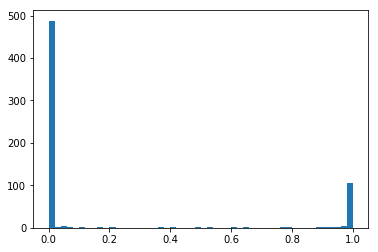

,Cutoff,Precision,Accuracy,F1,Recall
4,labels_gen_8,0.610000,0.4112,0.248980,0.156410
5,labels_gen_9,0.610000,0.4112,0.248980,0.156410
2,labels_gen_6,0.609524,0.4128,0.258586,0.164103
3,labels_gen_7,0.607843,0.4112,0.252033,0.158974
1,labels_gen_5,0.605505,0.4128,0.264529,0.169231
0,labels_gen_4,0.603604,0.4128,0.267465,0.171795


In [22]:
### Train generative model
train_25 = sparse.csr_matrix(Label_Matrix_to_GM_25.values)
GM_25 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_25.train(Label_Matrix_to_GM_25.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_25.values.T.shape[1], reg_param=1e-6)
train_25_marginals = GM_25.marginals(train_25)
train_25_marginals.shape
plt.hist(train_25_marginals, bins=50)
plt.show()
train_25_marginals_df=pd.DataFrame(train_25_marginals)
train_25_marginals_df.columns=['train_25_marginals']
train_25_marginals_df=pd.DataFrame(train_25_marginals)
train_25_marginals_df.columns=['train_25_marginals']
Label_Gen_25=Gen_Label_Cutoff(train_25_marginals_df,'train_25_marginals')
Accuracy_Metric_GM_25=calculate_accuracy_GM(Label_Gen_25,Final_df,'target')
Accuracy_Metric_GM_25

### Sixth Experiment with 30 features

In [23]:
### Create Label Matrix
Label_df_30=labelGeneratorWithProbDist(Final_df,nCol=30,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_30=Label_df_30.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_30=tempdf_30.columns[tempdf_30.isna().any()].tolist()
## Drop these cols
Label_df_30 = Label_df_30.drop(cols_2_labels_30, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_30=calculate_accuracy_metric(Label_df_30,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_30=Label_Accuracy_Metric_30[Label_Accuracy_Metric_30['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_30=Label_df_30[Label_to_GM_30]
Label_Accuracy_Metric_30.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
148,ProbDist_7_Column_121117,0.9856,0.728155,0.585938,0.649351,0.605519
149,ProbDist_8_ColumnR_121117,0.9856,0.517915,0.414062,0.460203,0.394481
128,ProbDist_7_Column_128910,0.9808,0.653465,0.516971,0.577259,0.526917
129,ProbDist_8_ColumnR_128910,0.9808,0.596774,0.483029,0.533911,0.473083
29,ProbDist_8_ColumnR_13271,0.9776,0.749186,0.598958,0.665702,0.621931
28,ProbDist_7_Column_13271,0.9776,0.506579,0.401042,0.447674,0.378069
177,ProbDist_8_ColumnR_140732,0.9744,0.652459,0.527851,0.583578,0.533662
176,ProbDist_7_Column_140732,0.9744,0.585526,0.472149,0.522761,0.466338
157,ProbDist_8_ColumnR_78499,0.9712,0.639871,0.519582,0.573487,0.512356
156,ProbDist_7_Column_78499,0.9712,0.621622,0.480418,0.541973,0.487644


Inferred cardinality: 2


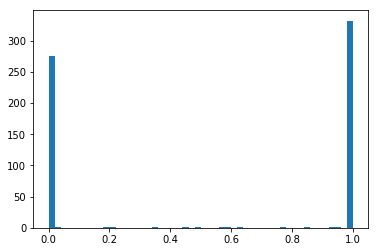

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.684543,0.5632,0.613861,0.556410
4,labels_gen_8,0.683386,0.5632,0.614951,0.558974
3,labels_gen_7,0.683230,0.5648,0.617978,0.564103
2,labels_gen_6,0.680982,0.5648,0.620112,0.569231
1,labels_gen_5,0.679878,0.5648,0.621170,0.571795
0,labels_gen_4,0.679758,0.5664,0.624133,0.576923


In [24]:
### Train generative model
train_30 = sparse.csr_matrix(Label_Matrix_to_GM_30.values)
GM_30 = GenerativeModel()
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
GM_30.train(Label_Matrix_to_GM_30.values, epochs=1000, decay=0.98, step_size= 0.08/ Label_Matrix_to_GM_30.values.T.shape[1], reg_param=1e-6)
train_30_marginals = GM_30.marginals(train_30)
train_30_marginals.shape
plt.hist(train_30_marginals, bins=50)
plt.show()
train_30_marginals_df=pd.DataFrame(train_30_marginals)
train_30_marginals_df.columns=['train_30_marginals']
train_30_marginals_df=pd.DataFrame(train_30_marginals)
train_30_marginals_df.columns=['train_30_marginals']
Label_Gen_30=Gen_Label_Cutoff(train_30_marginals_df,'train_30_marginals')
Accuracy_Metric_GM_30=calculate_accuracy_GM(Label_Gen_30,Final_df,'target')
Accuracy_Metric_GM_30

### Sixth Experiment with 35 features

In [25]:
### Create Label Matrix
Label_df_35=labelGeneratorWithProbDist(Final_df,nCol=35,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_35=Label_df_35.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_35=tempdf_35.columns[tempdf_35.isna().any()].tolist()
## Drop these cols
Label_df_35 = Label_df_35.drop(cols_2_labels_35, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_35=calculate_accuracy_metric(Label_df_35,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_35=Label_Accuracy_Metric_35[Label_Accuracy_Metric_35['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_35=Label_df_35[Label_to_GM_35]
Label_Accuracy_Metric_35.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
12,ProbDist_7_Column_93900,0.9776,0.771987,0.617188,0.685962,0.644845
13,ProbDist_8_ColumnR_93900,0.9776,0.483553,0.382812,0.427326,0.355155
50,ProbDist_3_Column_103590,0.9760,0.756667,0.592689,0.664714,0.624590
54,ProbDist_7_Column_103590,0.9760,0.756667,0.592689,0.664714,0.624590
51,ProbDist_4_ColumnR_103590,0.9760,0.503226,0.407311,0.450216,0.375410
55,ProbDist_8_ColumnR_103590,0.9760,0.503226,0.407311,0.450216,0.375410
224,ProbDist_7_Column_122136,0.9744,0.714754,0.575198,0.637427,0.592775
181,ProbDist_8_ColumnR_69524,0.9744,0.684211,0.550265,0.609971,0.563218
180,ProbDist_7_Column_69524,0.9744,0.557377,0.449735,0.497804,0.436782
225,ProbDist_8_ColumnR_122136,0.9744,0.529605,0.424802,0.471449,0.407225


Inferred cardinality: 2


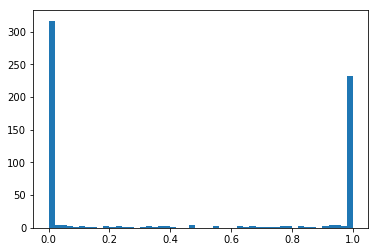

,Cutoff,Precision,Accuracy,F1,Recall
4,labels_gen_8,0.595833,0.4496,0.453968,0.366667
5,labels_gen_9,0.595745,0.4480,0.448000,0.358974
0,labels_gen_4,0.595506,0.4576,0.484018,0.407692
1,labels_gen_5,0.593156,0.4544,0.477795,0.400000
3,labels_gen_7,0.591270,0.4496,0.464174,0.382051
2,labels_gen_6,0.590734,0.4512,0.471495,0.392308


In [26]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved 
train_35 = sparse.csr_matrix(Label_Matrix_to_GM_35.values)
GM_35 = GenerativeModel()
GM_35.train(Label_Matrix_to_GM_35.values, epochs=1000, decay=0.7, step_size= 0.1/ Label_Matrix_to_GM_35.values.T.shape[1], reg_param=1e-6)
train_35_marginals = GM_35.marginals(train_35)
train_35_marginals.shape
plt.hist(train_35_marginals, bins=50)
plt.show()
train_35_marginals_df=pd.DataFrame(train_35_marginals)
train_35_marginals_df.columns=['train_35_marginals']
train_35_marginals_df=pd.DataFrame(train_35_marginals)
train_35_marginals_df.columns=['train_35_marginals']
Label_Gen_35=Gen_Label_Cutoff(train_35_marginals_df,'train_35_marginals')
Accuracy_Metric_GM_35=calculate_accuracy_GM(Label_Gen_35,Final_df,'target')
Accuracy_Metric_GM_35

###Sixth Experiment with 40 features

In [27]:
### Create Label Matrix
Label_df_40=labelGeneratorWithProbDist(Final_df,nCol=40,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_40=Label_df_40.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_40=tempdf_40.columns[tempdf_40.isna().any()].tolist()
## Drop these cols
Label_df_40 = Label_df_40.drop(cols_2_labels_40, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_40=calculate_accuracy_metric(Label_df_40,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_40=Label_Accuracy_Metric_40[Label_Accuracy_Metric_40['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_40=Label_df_40[Label_to_GM_40]
Label_Accuracy_Metric_40.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
215,ProbDist_8_ColumnR_87270,0.9776,0.697068,0.558747,0.620290,0.571195
214,ProbDist_7_Column_87270,0.9776,0.555921,0.441253,0.491994,0.428805
123,ProbDist_8_ColumnR_87531,0.9728,0.664474,0.530184,0.589781,0.537829
122,ProbDist_7_Column_87531,0.9728,0.588816,0.469816,0.522628,0.462171
176,ProbDist_7_Column_6269,0.9712,0.653465,0.522427,0.580645,0.528830
177,ProbDist_8_ColumnR_6269,0.9712,0.595395,0.477573,0.530015,0.471170
78,ProbDist_7_Column_73744,0.9680,0.790000,0.630319,0.701183,0.666116
79,ProbDist_8_ColumnR_73744,0.9680,0.455738,0.369681,0.408223,0.333884
101,ProbDist_8_ColumnR_7919,0.9664,0.700658,0.562005,0.623719,0.574503
100,ProbDist_7_Column_7919,0.9664,0.553333,0.437995,0.488954,0.425497


Inferred cardinality: 2


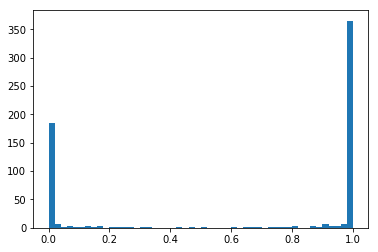

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.646310,0.5600,0.648787,0.651282
4,labels_gen_8,0.644444,0.5632,0.656604,0.669231
3,labels_gen_7,0.642686,0.5664,0.664188,0.687179
1,labels_gen_5,0.640187,0.5680,0.669927,0.702564
2,labels_gen_6,0.639344,0.5664,0.668299,0.700000
0,labels_gen_4,0.638889,0.5680,0.671533,0.707692


In [28]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_40 = sparse.csr_matrix(Label_Matrix_to_GM_40.values)
GM_40 = GenerativeModel()
GM_40.train(Label_Matrix_to_GM_40.values, epochs=1000, decay=0.8, step_size= 0.07/ Label_Matrix_to_GM_40.values.T.shape[1], reg_param=1e-6)
train_40_marginals = GM_40.marginals(train_40)
train_40_marginals.shape
plt.hist(train_40_marginals, bins=50)
plt.show()
train_40_marginals_df=pd.DataFrame(train_40_marginals)
train_40_marginals_df.columns=['train_40_marginals']
train_40_marginals_df=pd.DataFrame(train_40_marginals)
train_40_marginals_df.columns=['train_40_marginals']
Label_Gen_40=Gen_Label_Cutoff(train_40_marginals_df,'train_40_marginals')
Accuracy_Metric_GM_40=calculate_accuracy_GM(Label_Gen_40,Final_df,'target')
Accuracy_Metric_GM_40

### Sixth Experiment with 45 features

In [29]:
### Create Label Matrix
Label_df_45=labelGeneratorWithProbDist(Final_df,nCol=45,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_45=Label_df_45.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_45=tempdf_45.columns[tempdf_45.isna().any()].tolist()
## Drop these cols
Label_df_45 = Label_df_45.drop(cols_2_labels_45, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_45=calculate_accuracy_metric(Label_df_45,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_45=Label_Accuracy_Metric_45[Label_Accuracy_Metric_45['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_45=Label_df_45[Label_to_GM_45]
Label_Accuracy_Metric_45.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
254,ProbDist_7_Column_71472,0.9808,0.813725,0.650131,0.722787,0.688418
255,ProbDist_8_ColumnR_71472,0.9808,0.436482,0.349869,0.388406,0.311582
97,ProbDist_8_ColumnR_19521,0.9760,0.756579,0.600522,0.669578,0.627869
96,ProbDist_7_Column_19521,0.9760,0.500000,0.399478,0.444122,0.372131
85,ProbDist_8_ColumnR_19545,0.9696,0.746667,0.594164,0.661743,0.622112
165,ProbDist_8_ColumnR_141273,0.9696,0.646865,0.518519,0.575624,0.523102
4,ProbDist_7_Column_141664,0.9696,0.633987,0.513228,0.567251,0.511551
5,ProbDist_8_ColumnR_141664,0.9696,0.613333,0.486772,0.542773,0.488449
164,ProbDist_7_Column_141273,0.9696,0.600660,0.481481,0.534508,0.476898
84,ProbDist_7_Column_19545,0.9696,0.500000,0.405836,0.448023,0.377888


Inferred cardinality: 2


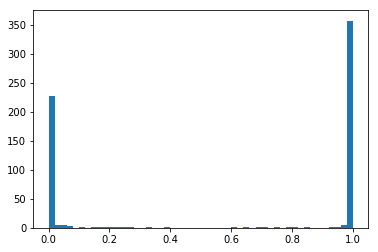

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.667598,0.5680,0.639037,0.612821
4,labels_gen_8,0.665746,0.5680,0.640957,0.617949
0,labels_gen_4,0.663978,0.5712,0.648294,0.633333
1,labels_gen_5,0.663978,0.5712,0.648294,0.633333
2,labels_gen_6,0.663978,0.5712,0.648294,0.633333
3,labels_gen_7,0.663957,0.5696,0.645586,0.628205


In [30]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_45 = sparse.csr_matrix(Label_Matrix_to_GM_45.values)
GM_45 = GenerativeModel()
GM_45.train(Label_Matrix_to_GM_45.values, epochs=1000, decay=0.8, step_size= 0.07/ Label_Matrix_to_GM_45.values.T.shape[1], reg_param=1e-6)
train_45_marginals = GM_45.marginals(train_45)
train_45_marginals.shape
plt.hist(train_45_marginals, bins=50)
plt.show()
train_45_marginals_df=pd.DataFrame(train_45_marginals)
train_45_marginals_df.columns=['train_45_marginals']
train_45_marginals_df=pd.DataFrame(train_45_marginals)
train_45_marginals_df.columns=['train_45_marginals']
Label_Gen_45=Gen_Label_Cutoff(train_45_marginals_df,'train_45_marginals')
Accuracy_Metric_GM_45=calculate_accuracy_GM(Label_Gen_45,Final_df,'target')
Accuracy_Metric_GM_45

### Experiment with 50 features

In [31]:
### Create Label Matrix
Label_df_50=labelGeneratorWithProbDist(Final_df,nCol=50,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_50=Label_df_50.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_50=tempdf_50.columns[tempdf_50.isna().any()].tolist()
## Drop these cols
Label_df_50 = Label_df_50.drop(cols_2_labels_50, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_50=calculate_accuracy_metric(Label_df_50,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_50=Label_Accuracy_Metric_50[Label_Accuracy_Metric_50['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_50=Label_df_50[Label_to_GM_50]
Label_Accuracy_Metric_50.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
72,ProbDist_3_Column_110404,0.9920,0.741100,0.590206,0.657102,0.614516
76,ProbDist_7_Column_110404,0.9920,0.741100,0.590206,0.657102,0.614516
73,ProbDist_4_ColumnR_110404,0.9920,0.511254,0.409794,0.454936,0.385484
77,ProbDist_8_ColumnR_110404,0.9920,0.511254,0.409794,0.454936,0.385484
318,ProbDist_3_Column_132004,0.9872,0.742765,0.604712,0.666667,0.625608
322,ProbDist_7_Column_132004,0.9872,0.742765,0.604712,0.666667,0.625608
319,ProbDist_4_ColumnR_132004,0.9872,0.493464,0.395288,0.438953,0.374392
323,ProbDist_8_ColumnR_132004,0.9872,0.493464,0.395288,0.438953,0.374392
264,ProbDist_3_Column_145996,0.9840,0.737179,0.605263,0.664740,0.622764
268,ProbDist_7_Column_145996,0.9840,0.737179,0.605263,0.664740,0.622764


Inferred cardinality: 2


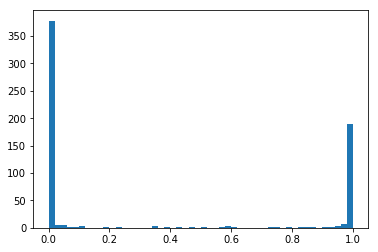

,Cutoff,Precision,Accuracy,F1,Recall
2,labels_gen_6,0.639175,0.4624,0.424658,0.317949
3,labels_gen_7,0.637306,0.4608,0.421955,0.315385
1,labels_gen_5,0.636816,0.4640,0.433164,0.328205
5,labels_gen_9,0.636364,0.4576,0.412478,0.305128
0,labels_gen_4,0.635922,0.4656,0.439597,0.335897
4,labels_gen_8,0.634921,0.4576,0.414508,0.307692


In [32]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_50 = sparse.csr_matrix(Label_Matrix_to_GM_50.values)
GM_50 = GenerativeModel()
GM_50.train(Label_Matrix_to_GM_50.values, epochs=1000, decay=0.8, step_size= 0.07/ Label_Matrix_to_GM_50.values.T.shape[1], reg_param=1e-6)
train_50_marginals = GM_50.marginals(train_50)
train_50_marginals.shape
plt.hist(train_50_marginals, bins=50)
plt.show()
train_50_marginals_df=pd.DataFrame(train_50_marginals)
train_50_marginals_df.columns=['train_50_marginals']
train_50_marginals_df=pd.DataFrame(train_50_marginals)
train_50_marginals_df.columns=['train_50_marginals']
Label_Gen_50=Gen_Label_Cutoff(train_50_marginals_df,'train_50_marginals')
Accuracy_Metric_GM_50=calculate_accuracy_GM(Label_Gen_50,Final_df,'target')
Accuracy_Metric_GM_50

In [33]:
### Create Label Matrix
Label_df_55=labelGeneratorWithProbDist(Final_df,nCol=55,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_55=Label_df_55.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_55=tempdf_55.columns[tempdf_55.isna().any()].tolist()
## Drop these cols
Label_df_55 = Label_df_55.drop(cols_2_labels_55, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_55=calculate_accuracy_metric(Label_df_55,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_55=Label_Accuracy_Metric_55[Label_Accuracy_Metric_55['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_55=Label_df_55[Label_to_GM_55]
Label_Accuracy_Metric_55.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
216,ProbDist_3_Column_139995,0.9920,0.740385,0.600000,0.662841,0.620968
220,ProbDist_7_Column_139995,0.9920,0.740385,0.600000,0.662841,0.620968
217,ProbDist_4_ColumnR_139995,0.9920,0.500000,0.400000,0.444444,0.379032
221,ProbDist_8_ColumnR_139995,0.9920,0.500000,0.400000,0.444444,0.379032
278,ProbDist_3_Column_138796,0.9888,0.741830,0.591146,0.657971,0.618123
282,ProbDist_7_Column_138796,0.9888,0.741830,0.591146,0.657971,0.618123
279,ProbDist_4_ColumnR_138796,0.9888,0.503205,0.408854,0.451149,0.381877
283,ProbDist_8_ColumnR_138796,0.9888,0.503205,0.408854,0.451149,0.381877
35,ProbDist_8_ColumnR_20464,0.9808,0.771987,0.618799,0.686957,0.647635
34,ProbDist_7_Column_20464,0.9808,0.477124,0.381201,0.423803,0.352365


Inferred cardinality: 2


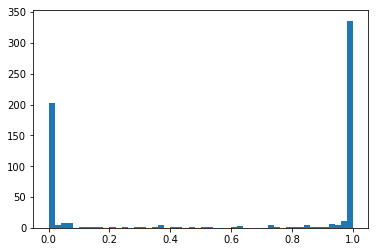

,Cutoff,Precision,Accuracy,F1,Recall
1,labels_gen_5,0.629540,0.5472,0.647572,0.666667
0,labels_gen_4,0.629187,0.5488,0.650990,0.674359
2,labels_gen_6,0.628641,0.5456,0.645885,0.664103
3,labels_gen_7,0.628079,0.5424,0.640704,0.653846
5,labels_gen_9,0.627848,0.5376,0.631847,0.635897
4,labels_gen_8,0.627500,0.5392,0.635443,0.643590


In [34]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_55 = sparse.csr_matrix(Label_Matrix_to_GM_55.values)
GM_55 = GenerativeModel()
GM_55.train(Label_Matrix_to_GM_55.values, epochs=1000, decay=0.7, step_size= 0.07/ Label_Matrix_to_GM_55.values.T.shape[1], reg_param=1e-6)
train_55_marginals = GM_55.marginals(train_55)
train_55_marginals.shape
plt.hist(train_55_marginals, bins=50)
plt.show()
train_55_marginals_df=pd.DataFrame(train_55_marginals)
train_55_marginals_df.columns=['train_55_marginals']
train_55_marginals_df=pd.DataFrame(train_55_marginals)
train_55_marginals_df.columns=['train_55_marginals']
Label_Gen_55=Gen_Label_Cutoff(train_55_marginals_df,'train_55_marginals')
Accuracy_Metric_GM_55=calculate_accuracy_GM(Label_Gen_55,Final_df,'target')
Accuracy_Metric_GM_55

In [35]:
### Create Label Matrix
Label_df_100=labelGeneratorWithProbDist(Final_df,nCol=100,pctCutoff=0.15)
## Get a list of clumns which were labled as only two classes out of 3
tempdf_100=Label_df_100.apply(lambda x :x.value_counts()).reset_index()
cols_2_labels_100=tempdf_100.columns[tempdf_100.isna().any()].tolist()
## Drop these cols
Label_df_100 = Label_df_100.drop(cols_2_labels_100, axis=1)
## Store the labeling function accuracy in a dataframe
Label_Accuracy_Metric_100=calculate_accuracy_metric(Label_df_100,Final_df, 'target')
## We will pass labels which have more than 60% coverage to generative model
Label_to_GM_100=Label_Accuracy_Metric_100[Label_Accuracy_Metric_100['Coverage']>=0.6]['Label_Name'].tolist()
Label_Matrix_to_GM_100=Label_df_100[Label_to_GM_100]
Label_Accuracy_Metric_100.head(10)

C:\Users\srai\AppData\Local\Continuum\anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Label_Name,Coverage,Precision,Recall,F1,Accuracy
178,ProbDist_3_Column_113593,0.9952,0.741935,0.592784,0.659026,0.617363
182,ProbDist_7_Column_113593,0.9952,0.741935,0.592784,0.659026,0.617363
179,ProbDist_4_ColumnR_113593,0.9952,0.506410,0.407216,0.451429,0.382637
183,ProbDist_8_ColumnR_113593,0.9952,0.506410,0.407216,0.451429,0.382637
501,ProbDist_8_ColumnR_40464,0.9792,0.796721,0.641161,0.710526,0.676471
552,ProbDist_7_Column_103510,0.9792,0.776316,0.617801,0.688047,0.650327
655,ProbDist_8_ColumnR_79662,0.9792,0.724919,0.584856,0.647399,0.601307
384,ProbDist_7_Column_110728,0.9792,0.675410,0.543536,0.602339,0.555556
385,ProbDist_8_ColumnR_110728,0.9792,0.563518,0.456464,0.504373,0.444444
654,ProbDist_7_Column_79662,0.9792,0.524752,0.415144,0.463557,0.398693


Inferred cardinality: 2


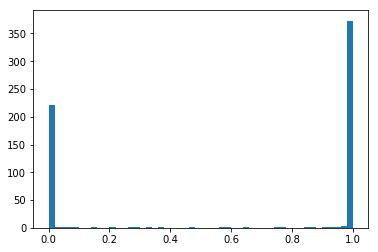

,Cutoff,Precision,Accuracy,F1,Recall
3,labels_gen_7,0.644501,0.5568,0.645327,0.646154
4,labels_gen_8,0.643411,0.5536,0.640927,0.638462
2,labels_gen_6,0.643038,0.5568,0.647134,0.651282
5,labels_gen_9,0.642487,0.5520,0.639175,0.635897
0,labels_gen_4,0.642317,0.5568,0.648030,0.653846
1,labels_gen_5,0.642317,0.5568,0.648030,0.653846


In [36]:
#this is good GM_5.train(Label_Matrix_to_GM.values, epochs=1000, decay=0.98, step_size= 0.05/ Label_Matrix_to_GM.values.T.shape[1], reg_param=1e-6)
#improved
train_100 = sparse.csr_matrix(Label_Matrix_to_GM_100.values)
GM_100 = GenerativeModel()
GM_100.train(Label_Matrix_to_GM_100.values, epochs=1000, decay=0.7, step_size= 0.07/ Label_Matrix_to_GM_100.values.T.shape[1], reg_param=1e-6)
train_100_marginals = GM_100.marginals(train_100)
train_100_marginals.shape
plt.hist(train_100_marginals, bins=50)
plt.show()
train_100_marginals_df=pd.DataFrame(train_100_marginals)
train_100_marginals_df.columns=['train_100_marginals']
train_100_marginals_df=pd.DataFrame(train_100_marginals)
train_100_marginals_df.columns=['train_100_marginals']
Label_Gen_100=Gen_Label_Cutoff(train_100_marginals_df,'train_100_marginals')
Accuracy_Metric_GM_100=calculate_accuracy_GM(Label_Gen_100,Final_df,'target')
Accuracy_Metric_GM_100

In [39]:
#Label_Gen_100.shape
Label_Gen_100.to_csv("C:\\NICE\\TMF_DATA\\BITSPilani\\IITH\\Classess\\7.AdvancedML\\Project\\MidSem\\Data_To_Nimesh\\DataProgrammingLabel_Exp1.csv")

In [93]:
Label_Matrix_to_GM_100.shape[1]

546

### Experiment Result Analysis

In [96]:
## Get the number of labels created by number of features used
label_df_list=[Label_Accuracy_Metric,Label_Accuracy_Metric_10,Label_Accuracy_Metric_15,Label_Accuracy_Metric_20,Label_Accuracy_Metric_25,Label_Accuracy_Metric_30,Label_Accuracy_Metric_35,Label_Accuracy_Metric_40,Label_Accuracy_Metric_45,Label_Accuracy_Metric_50,Label_Accuracy_Metric_55,Label_Accuracy_Metric_100]
label_Matrix=[Label_Matrix_to_GM,Label_Matrix_to_GM_10,Label_Matrix_to_GM_15,Label_Matrix_to_GM_20,Label_Matrix_to_GM_25,Label_Matrix_to_GM_30,Label_Matrix_to_GM_35,Label_Matrix_to_GM_40,Label_Matrix_to_GM_45,Label_Matrix_to_GM_50,Label_Matrix_to_GM_55,Label_Matrix_to_GM_100]
No_Feature_Used=[5,10,15,20,25,30,35,40,45,50,55,100]
No_Of_Labels_Generated=[]
label_matrix_gm=[]
for l in label_df_list:
    No_Of_Labels_Generated.append(l.shape[0])

for l in label_Matrix:
    label_matrix_gm.append(l.shape[1])
print(label_matrix_gm)
    
print(No_Of_Labels_Generated)
Input_Details=pd.concat([pd.DataFrame(No_Feature_Used),pd.DataFrame(No_Of_Labels_Generated),pd.DataFrame(label_matrix_gm)],axis=1)
Input_Details.columns=['No_Feature_Used','Total_No_Label_Generated','No_Label_To_GenerativeModel']
Input_Details

[26, 64, 84, 106, 128, 154, 200, 210, 224, 254, 278, 546]
[36, 70, 104, 142, 172, 212, 242, 282, 308, 338, 382, 670]


,No_Feature_Used,Total_No_Label_Generated,No_Label_To_GenerativeModel
0,5,36,26
1,10,70,64
2,15,104,84
3,20,142,106
4,25,172,128
5,30,212,154
6,35,242,200
7,40,282,210
8,45,308,224
9,50,338,254


In [99]:
## Getting Average accuracy statistics for each run
#Label_Accuracy_Metric.columns[1:]
Mean_Acc_Label=[]
for l in label_df_list:
    Mean_Acc_Label.append(l.mean().tolist())

Mean_Acc_Label_df=pd.DataFrame(Mean_Acc_Label)
Mean_Acc_Label_df.columns=Label_Accuracy_Metric.columns[1:]
temp=pd.DataFrame(No_Feature_Used)
temp.columns=['No_Feature_Used']
Mean_Acc_Label_df=pd.concat([temp,Mean_Acc_Label_df],axis=1)
Mean_Acc_Label_df

,No_Feature_Used,Coverage,Precision,Recall,F1,Accuracy
0,5,0.666667,0.580178,0.5,0.516568,0.5
1,10,0.832137,0.609203,0.5,0.537883,0.5
2,15,0.777015,0.601551,0.5,0.541149,0.5
3,20,0.742423,0.603607,0.5,0.518300,0.5
4,25,0.718288,0.602134,0.5,0.518817,0.5
5,30,0.705842,0.580238,0.5,0.531172,0.5
6,35,0.774215,0.587374,0.5,0.535845,0.5
7,40,0.721782,0.594480,0.5,0.535408,0.5
8,45,0.715242,0.599864,0.5,0.532165,0.5
9,50,0.730414,0.595366,0.5,0.528754,0.5


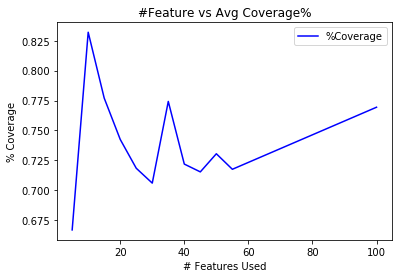

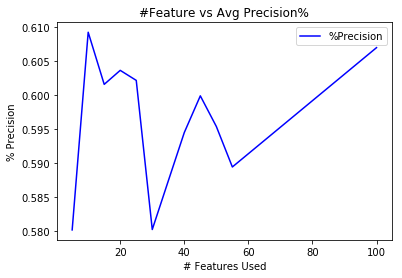

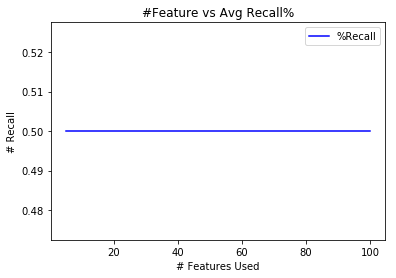

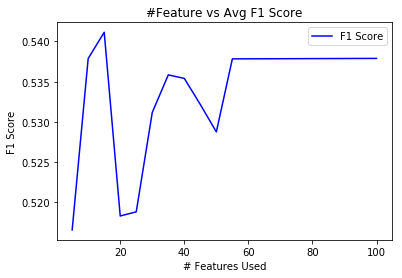

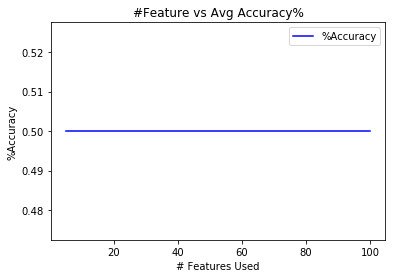

In [90]:
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Coverage'], color='blue',label='%Coverage')
plt.xlabel('# Features Used')
plt.ylabel('% Coverage')
plt.title('#Feature vs Avg Coverage%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Precision'], color='blue',label='%Precision')
plt.xlabel('# Features Used')
plt.ylabel('% Precision')
plt.title('#Feature vs Avg Precision%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Recall'], color='blue',label='%Recall')
plt.xlabel('# Features Used')
plt.ylabel('# Recall')
plt.title('#Feature vs Avg Recall%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['F1'], color='blue',label='F1 Score')
plt.xlabel('# Features Used')
plt.ylabel('F1 Score')
plt.title('#Feature vs Avg F1 Score')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Mean_Acc_Label_df['Accuracy'], color='blue',label='%Accuracy')
plt.xlabel('# Features Used')
plt.ylabel('%Accuracy')
plt.title('#Feature vs Avg Accuracy%')
plt.legend()
plt.show()

In [109]:
## Generative Model performance @90% probability cut-off
Gen_Model_list=[Accuracy_Metric_GM_5,Accuracy_Metric_GM_10,Accuracy_Metric_GM_15,Accuracy_Metric_GM_20,Accuracy_Metric_GM_25,Accuracy_Metric_GM_30,Accuracy_Metric_GM_35,Accuracy_Metric_GM_40,Accuracy_Metric_GM_45,Accuracy_Metric_GM_50,Accuracy_Metric_GM_55,Accuracy_Metric_GM_100]
Gen_Model_Performance_df=pd.DataFrame()
for l in Gen_Model_list:
    Gen_Model_Performance_df=Gen_Model_Performance_df.append(l[l['Cutoff']=='labels_gen_9'])

Gen_Model_Performance_df

,Cutoff,Precision,Accuracy,F1,Recall
5,labels_gen_9,0.690476,0.5040,0.483333,0.371795
5,labels_gen_9,0.559871,0.4352,0.494993,0.443590
5,labels_gen_9,0.559603,0.4336,0.488439,0.433333
5,labels_gen_9,0.566265,0.4464,0.520776,0.482051
5,labels_gen_9,0.610000,0.4112,0.248980,0.156410
5,labels_gen_9,0.684543,0.5632,0.613861,0.556410
5,labels_gen_9,0.595745,0.4480,0.448000,0.358974
5,labels_gen_9,0.646310,0.5600,0.648787,0.651282
5,labels_gen_9,0.667598,0.5680,0.639037,0.612821
5,labels_gen_9,0.636364,0.4576,0.412478,0.305128


In [108]:
pd.concat([temp,Gen_Model_Performance_df],axis=1)

ValueError: Shape of passed values is (6, 155), indices imply (6, 23)

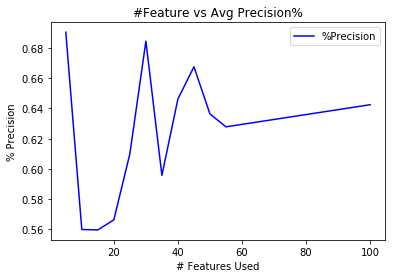

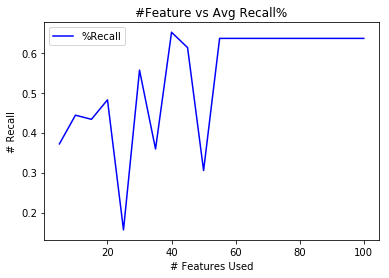

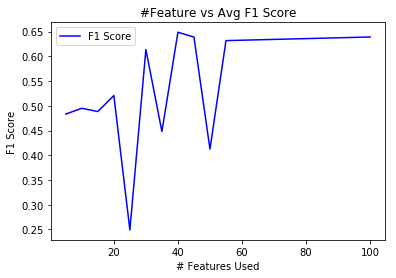

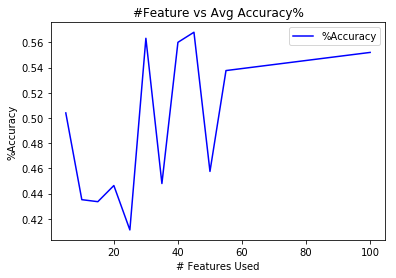

In [88]:
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Precision'], color='blue',label='%Precision')
plt.xlabel('# Features Used')
plt.ylabel('% Precision')
plt.title('#Feature vs Avg Precision%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Recall'], color='blue',label='%Recall')
plt.xlabel('# Features Used')
plt.ylabel('# Recall')
plt.title('#Feature vs Avg Recall%')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['F1'], color='blue',label='F1 Score')
plt.xlabel('# Features Used')
plt.ylabel('F1 Score')
plt.title('#Feature vs Avg F1 Score')
plt.legend()
plt.show()
plt.plot(No_Feature_Used, Gen_Model_Performance_df['Accuracy'], color='blue',label='%Accuracy')
plt.xlabel('# Features Used')
plt.ylabel('%Accuracy')
plt.title('#Feature vs Avg Accuracy%')
plt.legend()
plt.show()